In [2]:

import pandas as pd
data = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin1')
data.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [4]:
import numpy as np
np.unique(data['v1'])
np.unique(data['v2'])

array([' &lt;#&gt;  in mca. But not conform.',
       ' &lt;#&gt;  mins but i had to stop somewhere first.',
       ' &lt;DECIMAL&gt; m but its not a common car here so its better to buy from china or asia. Or if i find it less expensive. I.ll holla',
       ..., 'ÌÏ thk of wat to eat tonight.', 'ÌÏ v ma fan...',
       'ÌÏ wait 4 me in sch i finish ard 5..'], dtype=object)

In [5]:
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

# The following are the steps followed in this notebook
 
1. Data Loading & Exploration
2. Text Preprocessing (NLP)
3. Feature Engineering (Text → Numbers)
4. Model Selection & Training
5.  Model Evaluation Model Inference (Test on New SMS)


In [6]:
data.columns = ['class','Text']
data

,class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
#now lets understand about the data
print(data.info(),"\n")
print(data.describe(),"\n")
print(data.isnull().sum(),"\n")
print(data.duplicated().sum(),"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   5572 non-null   object
 1   Text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None 

       class                    Text
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30 

class    0
Text     0
dtype: int64 

403 



In [8]:
#from above observatoion u can see there are duplicate values ,lets check them
data[data.duplicated(subset='Text')]



,class,Text
102,ham,As per your request 'Melle Melle (Oru Minnamin...
153,ham,As per your request 'Melle Melle (Oru Minnamin...
206,ham,"As I entered my cabin my PA said, '' Happy B'd..."
222,ham,"Sorry, I'll call later"
325,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


<Axes: title={'center': 'Spam vs Ham Count'}, xlabel='class'>

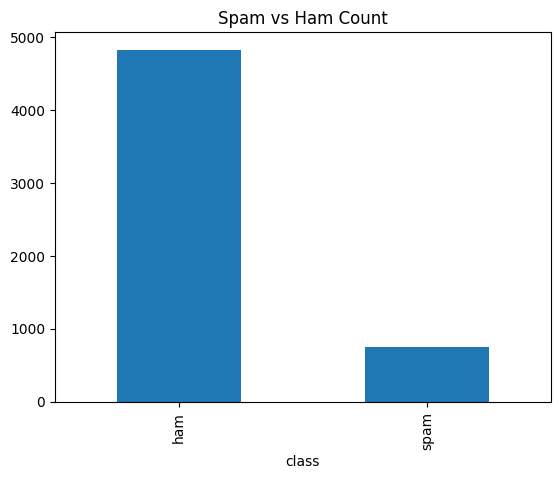

In [9]:
#class also imbalance we need to balance the classes,lets visulazie the imbalance
data['class'].value_counts().plot(kind='bar', title='Spam vs Ham Count')

In [10]:
# Check if duplicates are mostly ham or spam:
data[data.duplicated(subset='Text')]['class'].value_counts()


class
ham     309
spam     94
Name: count, dtype: int64

In [11]:
#since out of 5572 rows ,403 rows are duplicated lets remove them
data = data.drop_duplicates(subset='Text')

In [12]:
#data shape
data.shape

(5169, 2)

In [13]:
# now duplicates are removed
data[data.duplicated(subset='Text')]['class'].value_counts()


Series([], Name: count, dtype: int64)

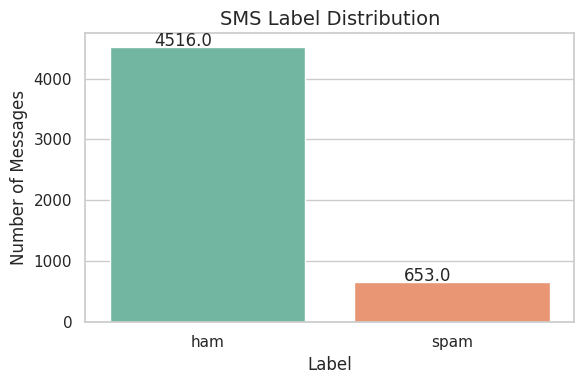

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", palette="pastel")

# Create a plot
plt.figure(figsize=(6, 4)) # 6 width , 4 height
ax = sns.countplot(x='class', data=data, palette=["#66c2a5", "#fc8d62"])  # greenish for ham, reddish for spam

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 20), ha='center')

# Title and labels
plt.title("SMS Label Distribution", fontsize=14)
plt.xlabel("Label")
plt.ylabel("Number of Messages")
plt.tight_layout()
plt.show()


# lets do the class balance by sampling, we had 2 options
1. To mention while training in model
2. To manually overpopulate

In [17]:
from sklearn.utils import resample

# Separate classes
spam_df = data[data['class'] == 'spam']
ham_df = data[data['class'] == 'ham']

# Oversample spam to match number of ham
spam_oversampled = resample(
    spam_df,
    replace=True,                # Sample with replacement
    n_samples=len(ham_df),       # Match ham count
    random_state=42              # Reproducibility
)

# Combine balanced dataset
df_balanced = pd.concat([ham_df, spam_oversampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Confirm balance
print(df_balanced['class'].value_counts())


class
ham     4516
spam    4516
Name: count, dtype: int64


In [18]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english')) #common words are removed here
lemmatizer = WordNetLemmatizer() #converts the words from one form to another like training to train,cars to car

def preprocess(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]

    return " ".join(clean_tokens)


In [20]:
df_balanced['clean_text'] = df_balanced['Text'].apply(preprocess)

In [21]:
print(df_balanced[['Text', 'clean_text']].sample(5))
#clean and preprocessed data

                                                   Text  \
6311  You will recieve your tone within the next 24h...   
2955       K I'll head out in a few mins, see you there   
7904                      IM LATE TELLMISS IM ON MY WAY   
6693  A å£400 XMAS REWARD IS WAITING FOR YOU! Our co...   
1822                            Think + da. You wil do.   

                                             clean_text  
6311  recieve tone within next term condition please...  
2955                                 k ill head min see  
7904                            im late tellmiss im way  
6693  xmas reward waiting computer randomly picked l...  
1822                                       think da wil  


In [23]:
data = data.copy()
data['clean_text'] = data['Text'].apply(preprocess)


# Feature Engineering (Text → Numbers)
1. *We'll use the popular TF-IDF (Term Frequency - Inverse Document Frequency) vectorizer, which:Assigns higher scores to words that are important in a messageDownweights common words (like "the", "you") across all messages*
2. *TF-IDF gives higher scores to unique, rare words
 Better for spam detection where keywords like free, win, urgent, prize matter.*

In [26]:
#From sklearn prewritten library we just import tfidf and pass to the api
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=3000)  # Limit to 3000 features (tune as needed)

# Fit on clean text
X = vectorizer.fit_transform(data['clean_text'])  # or df_balanced['clean_text']

# Labels: spam = 1, ham = 0
y = data['class'].map({'ham': 0, 'spam': 1})


In [27]:
print("Feature matrix shape:", X.shape)


Feature matrix shape: (5169, 3000)


#  Train a Model
1. X → Feature matrix (TF-IDF vectors)
2. y → Binary labels (0 = ham, 1 = spam)


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


#  Train Multiple Models



In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (Linear)": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n📊 Model: {name}")
    print(f"✅ Accuracy : {acc:.4f}")
    print(f"🎯 Precision: {prec:.4f}")
    print(f"🔁 Recall   : {rec:.4f}")
    print(f"💯 F1 Score : {f1:.4f}")



📊 Model: Naive Bayes
✅ Accuracy : 0.9729
🎯 Precision: 0.9905
🔁 Recall   : 0.7939
💯 F1 Score : 0.8814

📊 Model: Logistic Regression
✅ Accuracy : 0.9507
🎯 Precision: 1.0000
🔁 Recall   : 0.6107
💯 F1 Score : 0.7583

📊 Model: SVM (Linear)
✅ Accuracy : 0.9768
🎯 Precision: 0.9820
🔁 Recall   : 0.8321
💯 F1 Score : 0.9008

📊 Model: Random Forest
✅ Accuracy : 0.9749
🎯 Precision: 0.9817
🔁 Recall   : 0.8168
💯 F1 Score : 0.8917

📊 Model: XGBoost
✅ Accuracy : 0.9729
🎯 Precision: 0.9402
🔁 Recall   : 0.8397
💯 F1 Score : 0.8871


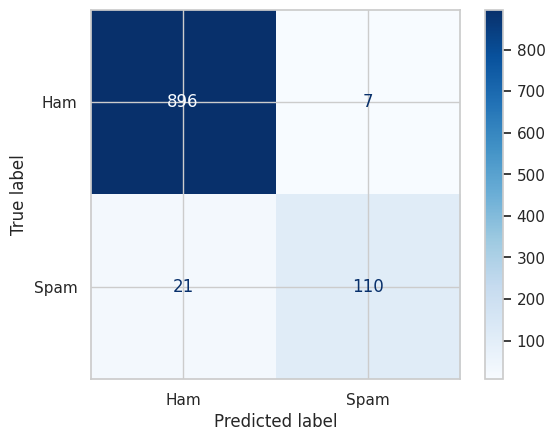

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = models['XGBoost'] 
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap="Blues")


# Now lets apply the hyper parameter tuning

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


In [33]:
# Feature Vectorization with N-Grams
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

In [35]:
# Stratified Train-Test Split
X = data['clean_text']
y = data['class'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# Define Pipelines + Hyperparameter Grids

In [36]:
pipelines = {
    "Naive Bayes": Pipeline([
        ('tfidf', vectorizer),
        ('clf', MultinomialNB())
    ]),
    "Logistic Regression": Pipeline([
        ('tfidf', vectorizer),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
    ]),
    "SVM": Pipeline([
        ('tfidf', vectorizer),
        ('clf', LinearSVC(class_weight='balanced'))
    ])
}

param_grids = {
    "Naive Bayes": {
        'clf__alpha': [0.1, 0.5, 1.0]
    },
    "Logistic Regression": {
        'clf__C': [0.1, 1, 10]
    },
    "SVM": {
        'clf__C': [0.1, 1, 10]
    }
}


In [37]:
best_models = {}

for name in pipelines:
    print(f"\n🔍 Tuning {name}...")
    
    grid = GridSearchCV(pipelines[name], param_grids[name], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    best_models[name] = best_model
    
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"✅ Best Params: {grid.best_params_}")
    print(f"✅ Accuracy : {acc:.4f}")
    print(f"🎯 Precision: {prec:.4f}")
    print(f"🔁 Recall   : {rec:.4f}")
    print(f"💯 F1 Score : {f1:.4f}")



🔍 Tuning Naive Bayes...
✅ Best Params: {'clf__alpha': 0.1}
✅ Accuracy : 0.9749
🎯 Precision: 0.9565
🔁 Recall   : 0.8397
💯 F1 Score : 0.8943

🔍 Tuning Logistic Regression...
✅ Best Params: {'clf__C': 10}
✅ Accuracy : 0.9787
🎯 Precision: 0.9291
🔁 Recall   : 0.9008
💯 F1 Score : 0.9147

🔍 Tuning SVM...
✅ Best Params: {'clf__C': 1}
✅ Accuracy : 0.9787
🎯 Precision: 0.9291
🔁 Recall   : 0.9008
💯 F1 Score : 0.9147


In [54]:
# Fit vectorizer on X_train before saving
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=3000)
vectorizer.fit(X_train)



TfidfVectorizer(max_features=3000, ngram_range=(1, 2))

In [41]:
# Now lets test our trained models
best_model = models['XGBoost'] 


In [50]:
#preprocessing
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(clean_tokens)


In [46]:
# utility function
def predict_sms(text, model, vectorizer):
    cleaned = preprocess(text)
    vector = vectorizer.transform([cleaned])
    pred = model.predict(vector)[0]
    label = "Spam 🚨" if pred == 1 else "Ham ✅"
    return label


In [56]:
print(predict_sms("kill u!", best_model, vectorizer))
print(predict_sms("I'll call you after my meeting", best_model, vectorizer))


Ham ✅
Ham ✅


In [ ]:
import pickle

# Save model
with open("spam_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Save vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
